In [19]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
import datetime

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The rich extension is already loaded. To reload it, use:
  %reload_ext rich
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
holidays = [
    datetime.date(2016,12,25),
    datetime.date(2017,12,25),
    datetime.date(2018,12,25),    
    datetime.date(2019,12,25),    
    datetime.date(2020,12,25),
    datetime.date(2021,12,25),  
    
    datetime.date(2016,11,25),
    datetime.date(2017,11,24),
    datetime.date(2018,11,23),    
    datetime.date(2019,11,29),    
    datetime.date(2020,11,27),
    datetime.date(2021,11,26),     
]

In [21]:
import pandas as pd
import statsmodels.api as sm


dir = "./data/"
cdf = pd.read_csv(dir+"data4columbia_credit.csv")
cdf.columns=['company','date','data']
cdf.date = pd.to_datetime(cdf.date)

t = (cdf["date"] - pd.Timestamp("1900-01-01")).dt.total_seconds().to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)
cdf['t'] = t
cdf['is_holiday'] = cdf.date.apply(lambda x : x.date() in holidays).astype(int)
cdf

company       date           data         t  is_holiday
0       ef1bcca724f3 2016-01-01  266648.924500  0.000000           0
1       ef1bcca724f3 2016-01-02  330109.961300  0.000399           0
2       ef1bcca724f3 2016-01-03  248299.827200  0.000798           0
3       ef1bcca724f3 2016-01-04  146428.339600  0.001198           0
4       ef1bcca724f3 2016-01-05  146854.815500  0.001597           0
...              ...        ...            ...       ...         ...
116654  e2415cb7f63d 2022-11-05    1149.371612  0.998004           0
116655  e2415cb7f63d 2022-11-06     890.458833  0.998403           0
116656  e2415cb7f63d 2022-11-07    1233.454763  0.998802           0
116657  e2415cb7f63d 2022-11-08    2478.464933  0.999202           0
116658  e2415cb7f63d 2022-11-09    2027.376001  0.999601           0

[116659 rows x 5 columns]

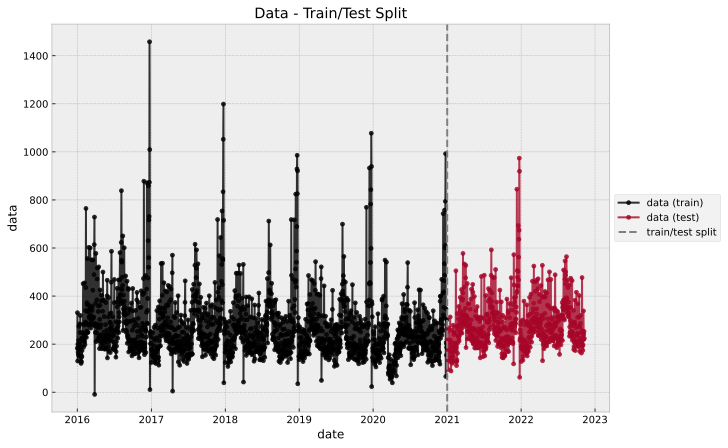

In [22]:
import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)

def run_decompose(cdf, company_id, split_date):
    data = cdf[cdf.company==cdf.company.unique()[company_id]].set_index('date')
    data['t'] = range(len(data))
    df_train = data[data.index < split_date]
    df_test = data[data.index >= split_date]
    return df_train, df_test

train_test_date =  datetime.datetime(2021,1,1)
df_train, df_test = run_decompose(cdf, 1, train_test_date)
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="data",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="data (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Data - Train/Test Split");

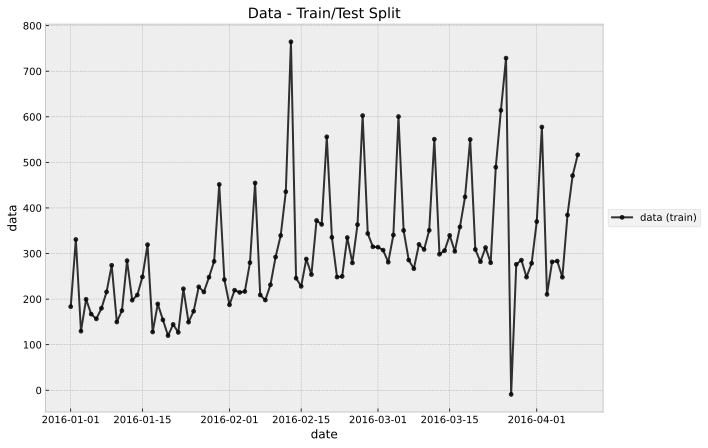

In [23]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="data",
    data=df_train.iloc[0:100],
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Data - Train/Test Split");

/tmp/ipykernel_419806/1734417093.py:2: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, β_holiday, σ]


Done


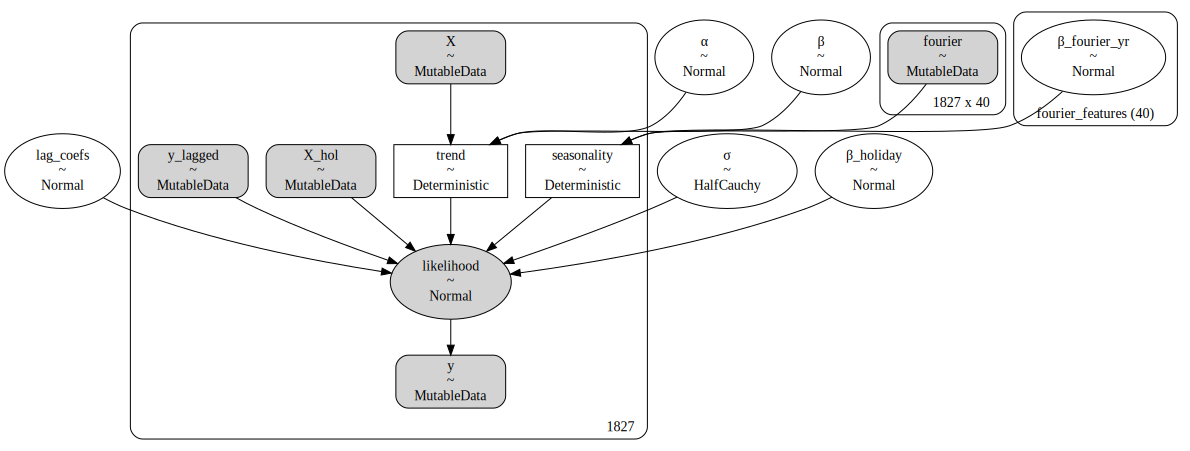

In [24]:
import numpy as np
from scipy.ndimage.interpolation import shift

x_train = df_train['t']
x_hol_train = df_train['is_holiday']
y_train = df_train.data

x_test = df_test['t']
x_hol_test = df_test['is_holiday']
y_test = df_test.data


"""
data ~ (α + βX) + seasonality
seasonality ~ β_four * fourier_modes
"""

df_train['date'] = df_train.index
date_train = df_train["date"]
data_train = df_train["data"]

df = df_train

#fourier modes
n_order = 20
periods = df_train["date"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

coords = {
    "fourier_features": np.arange(2 * n_order),  
}

with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    
    # data containers
    X = pm.MutableData("X", x_train)
    x_hol = pm.MutableData("X_hol", x_hol_train)    
    y = pm.MutableData("y", y_train)
    y_lagged = pm.MutableData("y_lagged", shift(y_train,7,cval=y_train.mean())) 
    
    α = pm.Normal("α", mu=np.mean(y_train), sigma=np.std(y_train))
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.HalfCauchy("σ", beta=0.1)
    
    β_holiday = pm.Normal("β_holiday", mu=0, sigma=1)
    
    # autocorrelation lag
    lag_coef = pm.Normal("lag_coefs", mu=0, sigma=1)
    
    X_four = pm.MutableData("fourier", fourier_features)    
    β_fourier_yr = pm.Normal("β_fourier_yr", mu=0, sigma=1, dims="fourier_features")
    
    seasonality = pm.Deterministic(
        "seasonality",  pm.math.dot(β_fourier_yr, X_four.T)
    )    
    
    trend = pm.Deterministic("trend", α + β * X)
    ar = lag_coef * y_lagged
    
    #additive seasonality
    # μ = (trend * (seasonality + seasonality_wk + x_hol * β_holiday ))
    μ = (trend + ar) * (1 + seasonality + x_hol * β_holiday)
    
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

print("Done")
pm.model_to_graphviz(linear_with_seasonality)


In [25]:
linear_with_seasonality

           α ~ Normal(267, 132)
           β ~ Normal(0, 1)
           σ ~ HalfCauchy(0, 0.1)
   β_holiday ~ Normal(0, 1)
   lag_coefs ~ Normal(0, 1)
β_fourier_yr ~ Normal(0, 1)
 seasonality ~ Deterministic(f(β_fourier_yr))
       trend ~ Deterministic(f(α, β))
  likelihood ~ Normal(f(lag_coefs, β_holiday, α, β_fourier_yr, β), σ)

Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, β_holiday, σ]


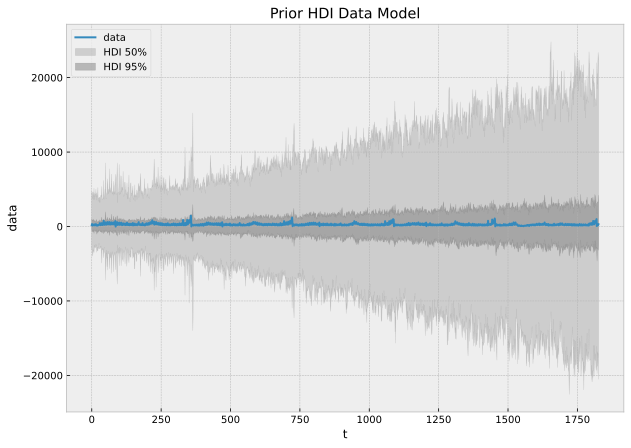

In [26]:
with linear_with_seasonality:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)

fig, ax = plt.subplots()

sns.lineplot(
    x="t", y="data", data=df_train, color="C0", label="data", ax=ax
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Data Model");
fig.savefig('prior_hdi1.png')

In [27]:
with linear_with_seasonality:
    temp_idata = pm.sample(
        target_accept=0.9, draws=100, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)
    
az.summary(data=temp_idata)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, β_holiday, lag_coefs, β_fourier_yr]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 212 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
α                112.485  8.155  97.619  127.683      0.711    0.504  \
β                 -0.017  0.004  -0.024   -0.010      0.000    0.000   
β_holiday         -0.231  0.083  -0.397   -0.091      0.004    0.003   
lag_coefs          0.634  0.024   0.590    0.680      0.002    0.001   
β_fourier_yr[0]   -0.016  0.011  -0.033    0.006      0.001    0.000   
...                  ...    ...     ...      ...        ...      ...   
trend[1822]       80.835  5.987  70.539   91.784      0.388    0.277   
trend[1823]       80.818  5.988  70.522   91.769      0.388    0.277   
trend[1824]       80.801  5.988  70.505   91.753      0.388    0.276   
trend[1825]       80.783  5.989  70.488   91.737      0.388    0.276   
trend[1826]       80.766  5.989  70.471   91.721      0.388    0.276   

                 ess_bulk  ess_tail  r_hat  
α                   133.0     197.0   1.03  
β                   283.0     244.0   1.01  
β_holiday           524.0     283.0   1.00  
lag_coefs           149.0     179.0   1.02  
β_fourier_yr[0]     342.0     240.0   1.01  
...                   ...       ...    ...  
trend[1822]         240.0     311.0   1.01  
trend[1823]         240.0     311.0   1.01  
trend[1824]         241.0     311.0   1.01  
trend[1825]         241.0     311.0   1.01  
trend[1826]         242.0     311.0   1.01  

[3699 rows x 9 columns]

array([[<Axes: title={'center': 'α'}>,
        <Axes: title={'center': 'α'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β'}>,
        <Axes: title={'center': 'β'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β_holiday'}>,
        <Axes: title={'center': 'β_holiday'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'lag_coefs'}>,
        <Axes: title={'center': 'lag_coefs'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'σ'}>,
        <Axes: title={'center': 'σ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

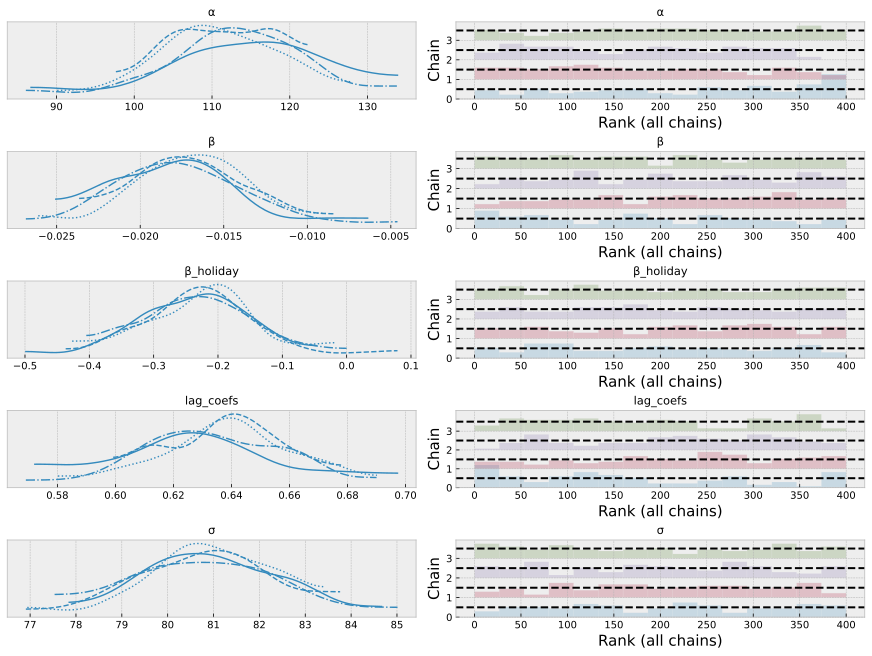

In [28]:
az.plot_trace(
    data=temp_idata,
    compact=True,
    var_names=['α','β','β_holiday','lag_coefs','σ'],
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)

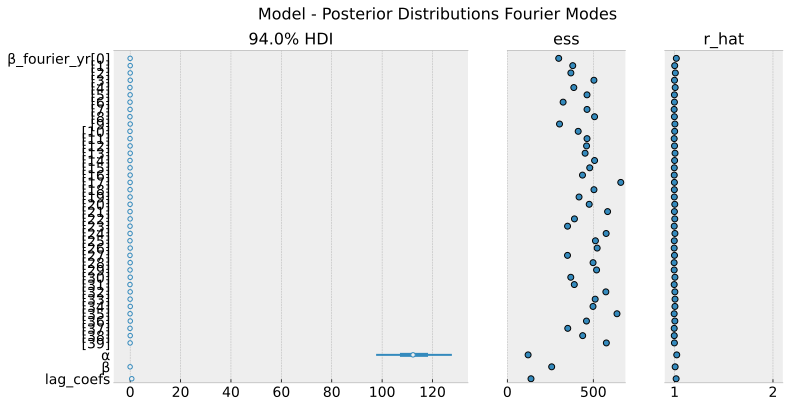

In [29]:
ax = az.plot_forest(
    kind="forestplot",
    data=temp_idata,
    var_names=["β_fourier_yr",'α','β','lag_coefs'],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Model - Posterior Distributions Fourier Modes", fontsize=16
);

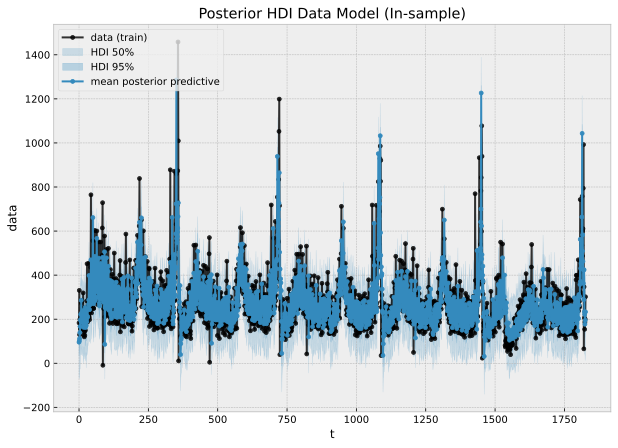

In [30]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=df_train['t'],
    y=temp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Data Model (In-sample)");

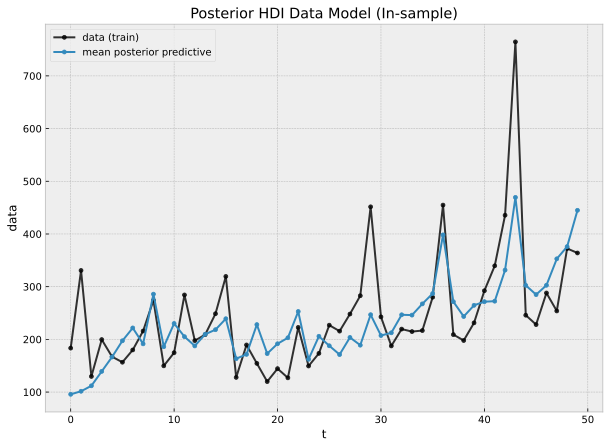

In [31]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_train.iloc[0:50],
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
)
sns.lineplot(
    x=df_train['t'].iloc[0:50],
    y=temp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)[0:50],
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Data Model (In-sample)");

In [32]:
# Update data reference.

#fourier
n_order = 20
df_test['date'] = df_test.index
periods = df_test["date"].dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


with linear_with_seasonality:
    pm.set_data({"X": x_test, 'X_hol': x_hol_test, 'y':y_test, 'fourier' : fourier_features_test, 'y_lagged': shift(y_test,7)})
    ppc_test = pm.sample_posterior_predictive(temp_idata, model=linear_with_seasonality)
ppc_test

Sampling: [likelihood]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

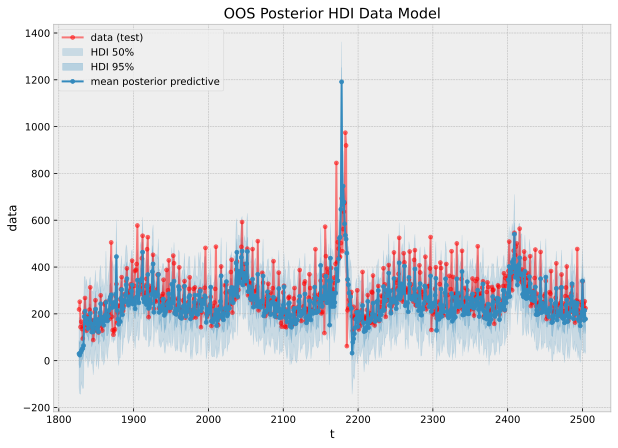

In [33]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_test,
    marker="o",
    color="red",
    alpha=0.5,
    markersize=4,
    markeredgecolor="red",
    label="data (test)",
)
az.plot_hdi(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=df_test['t'],
    y=ppc_test.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="OOS Posterior HDI Data Model");

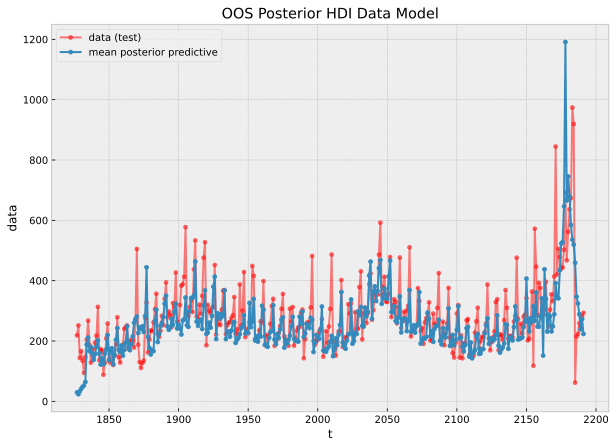

In [34]:
fig, ax = plt.subplots()

sns.lineplot(
    x="t",
    y="data",
    data=df_test.iloc[0:365],
    marker="o",
    color="red",
    alpha=0.5,
    markersize=4,
    markeredgecolor="red",
    label="data (test)",
)
sns.lineplot(
    x=df_test['t'].iloc[0:365],
    y=ppc_test.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)[0:365],
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="OOS Posterior HDI Data Model");

In [36]:
res_pred = np.array(ppc_test.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1))
res_true = df_test.data
from sklearn.metrics import mean_squared_error
mean_squared_error(res_true,res_pred)

5986.553344847329